In [70]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tqdm as tqdm
import Utils

import tensorflow as tf
import tensorflow 

from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.regularizers import l2
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import scipy

In [133]:
def load_data(surface_path, target_path):
    targets = pd.read_csv(target_path, skiprows=2, parse_dates=True, index_col=0)
    targets = pd.DataFrame(targets['Close'])

    surfaces = pd.read_csv(surface_path, parse_dates=True, index_col=[0,1])

    dates = surfaces.index.get_level_values(0).unique()
    dates = pd.Series(list(set(targets.index).intersection(set(dates))))
    dates = dates.sort_values()


    targets = targets.loc[dates]
    surfaces = surfaces.loc[dates]
    return surfaces, targets

def target_volatility(surfaces, targets):
    rets = Utils.convert_to_daily_returns(targets)
    volatility = rets.rolling(window=60).std()*np.sqrt(252)
    dates = volatility.dropna().index
    return surfaces.loc[dates], volatility.dropna()


def stack_days(surfaces, targets, stacks):

    dim = len(surfaces.index.get_level_values(0).unique())
    dim1 = len(surfaces.index.get_level_values(1).unique())

    surfaces_np = surfaces.values.reshape((dim, dim1, surfaces.shape[1]))

    stacked_surfaces = np.zeros((len(surfaces_np)-stacks, dim1, surfaces.shape[1], stacks))
    
    for i in range(len(surfaces_np)-stacks):
        temp = np.stack(surfaces_np[i:i+stacks]).transpose(1,2,0)
        stacked_surfaces[i] = temp

    stacked_dates = surfaces.index.get_level_values(0).unique()[stacks:]
    
    return stacked_surfaces, targets.loc[stacked_dates], stacked_dates


def lag_targets(surfaces, targets, lag, dates):
    lagged = targets.shift(-lag)
    return surfaces[:-lag], lagged.dropna(), dates[lag:]


def train_test_split(test_start, test_end, dates, surfaces, targets):
    test_dates = pd.Series(dates, index=dates)[test_start:test_end]
    
    start_ind = dates.get_loc(test_dates.iloc[0])
    end_ind = dates.get_loc(test_dates.iloc[-1]) + 1
        
    surfaces_test = surfaces[start_ind:end_ind]
    targets_test = targets.to_numpy()[start_ind:end_ind]
    
    surfaces_train = surfaces[:start_ind]
    surfaces_train = np.concatenate((surfaces_train,surfaces[end_ind:]))

    targets_train = targets.to_numpy()[:start_ind]
    targets_train = np.concatenate((targets_train,targets.to_numpy()[end_ind:]))
    
    train_dates = pd.Series(dates, index=dates).loc[~pd.Series(dates, index=dates).index.isin(test_dates)].index
    
    return surfaces_train, surfaces_test, targets_train, targets_test, train_dates, test_dates
    
    
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [183]:
surfaces, targets = load_data("processed_data/SPX.csv", "data/VIX.csv")

#surfaces, targets = target_volatility(surfaces, targets)

stacked_surfaces, stacked_targets, dates = stack_days(surfaces, targets, 20)

stacked_surfaces, stacked_targets_lagged, dates = lag_targets(stacked_surfaces, stacked_targets, 10, dates)

surfaces_train, surfaces_test, targets_train, targets_test, train_dates, test_dates = train_test_split('2019', '2023', dates, stacked_surfaces, stacked_targets_lagged)

input_shape = surfaces_train[0].shape

In [184]:
model = keras.models.Sequential()

model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.0001), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.Conv2D(128, (3, 3), kernel_regularizer=l2(0.0001), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), kernel_regularizer=l2(0.0001), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


#model.add(layers.BatchNormalization())


model.add(layers.Flatten())

model.add(layers.Dense(256, kernel_regularizer=l2(0.0005), activation='relu'))

model.add(layers.Dense(128, kernel_regularizer=l2(0.0005), activation='relu'))
#model.add(layers.Dropout(0.1))

model.add(layers.Dense(64, kernel_regularizer=l2(0.0005), activation='relu'))

model.add(layers.Dense(1, activation='linear'))

In [185]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(),
              metrics=[r_square, tf.keras.losses.Huber()])

K.set_value(model.optimizer.learning_rate, 0.005)

history = model.fit(surfaces_train, targets_train, epochs=50, batch_size=64)



Epoch 1/50
90/90 [==============================] - 6s 60ms/step - loss: 9.5815 - r_square: -6.8051 - huber_loss: 9.4259
Epoch 2/50
90/90 [==============================] - 5s 56ms/step - loss: 3.1067 - r_square: 0.6359 - huber_loss: 3.0129
Epoch 3/50
90/90 [==============================] - 5s 59ms/step - loss: 2.8454 - r_square: 0.6787 - huber_loss: 2.7659
Epoch 4/50
90/90 [==============================] - 6s 61ms/step - loss: 2.7689 - r_square: 0.6976 - huber_loss: 2.6928
Epoch 5/50
90/90 [==============================] - 6s 63ms/step - loss: 2.7026 - r_square: 0.7093 - huber_loss: 2.6308
Epoch 6/50
90/90 [==============================] - 6s 64ms/step - loss: 2.6306 - r_square: 0.7200 - huber_loss: 2.5613
Epoch 7/50
90/90 [==============================] - 6s 65ms/step - loss: 2.5527 - r_square: 0.7340 - huber_loss: 2.4862
Epoch 8/50
90/90 [==============================] - 6s 67ms/step - loss: 2.4683 - r_square: 0.7483 - huber_loss: 2.4042
Epoch 9/50
90/90 [=====================

24/24 - 0s - loss: 3.1734 - r_square: -1.1163e+00 - huber_loss: 3.1326 - 471ms/epoch - 20ms/step


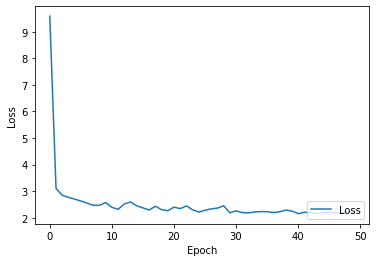

In [186]:
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

test_loss = model.evaluate(surfaces_test,  targets_test, verbose=2)

In [187]:
def plot_train_fit(surfaces_train, targets_train, dates_train):
        
    preds = model.predict(surfaces_train)
    print('R2: ')
    print(r2_score(targets_train, preds))
    print()
    
    print('MSE: ')
    print(mean_squared_error(targets_train, preds))
    print()
    
    test = pd.DataFrame(columns=['preds', 'targets'], index=dates_train)
    test['preds'] = preds
    test['targets'] = targets_train
    
    print('Corr: ')
    print(test.corr().iloc[0,1])
    print()
    
    print('Mean Absolute Error: ')
    print(np.abs(preds - targets_train).mean())
    print()
    
    print('Stdev Absolute Error: ')
    print(np.abs(preds - targets_train).std())
    print()
    
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)
    plt.plot(dates_train, targets_train, label='Realized')
    plt.plot(dates_train, preds, label='Model')
    plt.legend()

R2: 
0.8092883484753748

MSE: 
14.428087178835016

Corr: 
0.9003975144589821

Mean Absolute Error: 
2.544261988042169

Stdev Absolute Error: 
2.8204287112137267



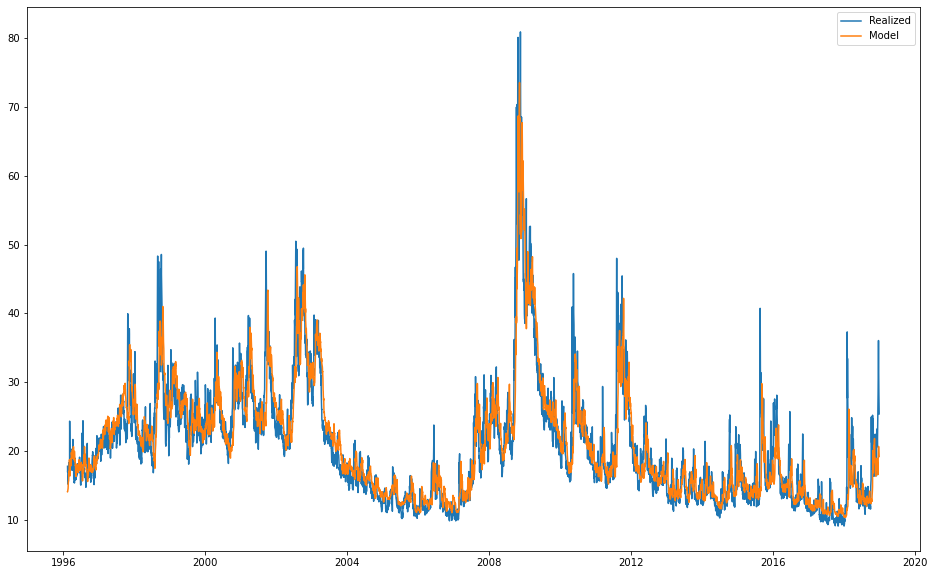

In [188]:
plot_train_fit(surfaces_train, targets_train, train_dates)

R2: 
0.5036300296878329

MSE: 
45.1702910175989

Corr: 
0.7310388035223464

Mean Absolute Error: 
3.5994934999375117

Stdev Absolute Error: 
5.675732337021056



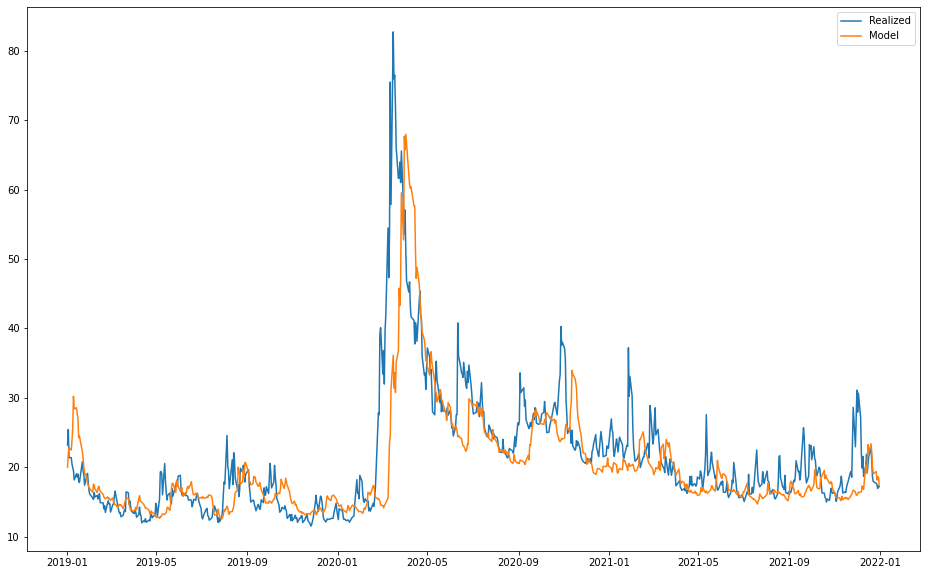

In [189]:
plot_train_fit(surfaces_test, targets_test, test_dates)